# Set up

## Package Loading

In [1]:
import pandas as pd
import numpy as np
import itertools
!pip install emoji
import emoji
import re
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
import matplotlib.pyplot as plt
import time
import joblib
import gzip
import json
import seaborn as sns
#from google.colab import drive
#drive.mount('/content/drive')

Looking in indexes: https://int.repositories.cloud.sap/artifactory/api/pypi/build-releases-pypi/simple, https://int.repositories.cloud.sap/artifactory/api/pypi/build-milestones-pypi/simple


You should consider upgrading via the 'c:\users\d073999\miniconda3\python.exe -m pip install --upgrade pip' command.


Looking in indexes: https://int.repositories.cloud.sap/artifactory/api/pypi/build-releases-pypi/simple, https://int.repositories.cloud.sap/artifactory/api/pypi/build-milestones-pypi/simple


You should consider upgrading via the 'c:\users\d073999\miniconda3\python.exe -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\D073999\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\D073999\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Set Up paths

In [2]:
# Parent paths
parent_path = '/content/drive/My Drive/'


#Specific paths
path_hyperparameters_nb = parent_path+"Web_Mining_Project/classifier_parameters/best_parameters/nb.csv"
path_hyperparameters_knn = parent_path+"Web_Mining_Project/classifier_parameters/best_parameters/knn.csv"
path_hyperparameters_rf = parent_path+"Web_Mining_Project/classifier_parameters/best_parameters/rf.csv"
path_hyperparameters_svm = parent_path+"Web_Mining_Project/classifier_parameters/best_parameters/svm.csv"

path_best_parameters_nb = parent_path+"Web_Mining_Project/classifier_parameters/nb.pkl"
path_best_parameters_knn = parent_path+"Web_Mining_Project/classifier_parameters/knn.pkl"
path_best_parameters_rf = parent_path+"Web_Mining_Project/classifier_parameters/rf.pkl"
path_best_parameters_svm = parent_path+"Web_Mining_Project/classifier_parameters/svm.pkl"
#dataset paths 
path_complete_dataset = parent_path + "Web_Mining_Project/data/complete_dataset.csv"
path_shortend_dataset = parent_path + "Web_Mining_Project/data/shortend10000_dataset.csv"

## Set Up Functions

In [3]:
# function for evaluation(confusion matrix)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# function for sentiment label creating 
def create_labels_from_rating(score):
  score = int(score)
  if score <= 2:
    return 0 #negative
  elif score == 3:
    return 1 #neutral
  else:
    return 2 #positive

# Data Download and Exploration

In [15]:
# create dataframe 
df = pd.read_csv("./train_tweet.csv", sep=',')
print(df.shape)
df.head()

(31962, 3)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [7]:
# General Information and Null values
print(df.isnull().any())
print()
df.info()
print()
print(df.dtypes)
print()
#print(df.overall.describe())
print()
# plot the score & check for the distribution of the star ratings 
#sns.countplot(df.overall)
plt.show()
print()

id       False
label    False
tweet    False
dtype: bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB

id        int64
label     int64
tweet    object
dtype: object





# Data Preprocessing and further Exploration

## Label creation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


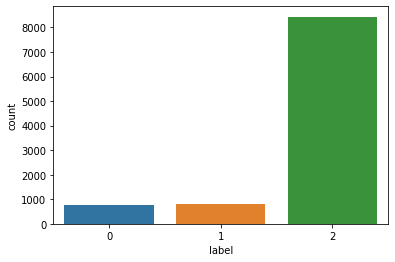

In [26]:
df['label'] = df['overall'].apply(create_labels_from_rating)
# plot the score & check for the distribution of the star ratings 
sns.countplot(df.label)
plt.show()

## Feature Generation and Selection

In [27]:
# Frequency encoding using value_counts function
reviewerID_freq = df['reviewerID'].value_counts()
# Mapping the encoded values with original data
df['reviewer_amount_of_reviews'] = df['reviewerID'].apply(lambda x : reviewerID_freq[x])
# detecting mean of ratings score per user
df['reviewer_mean_score'] = df.groupby(['reviewerID'])['overall'].transform(lambda x: x.mean())
df.drop(columns=['reviewTime', 'reviewerName', 'vote', 'style', 'image'], inplace=True)
print(df.shape)

(10000, 10)


In [28]:
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))] 
df = df[df['summary'].apply(lambda x: isinstance(x, str))]
df.dropna(inplace=True)
print(df.shape)
print(df.head())

(9999, 10)
   overall  verified      reviewerID        asin  \
0      5.0      True  A1HP7NVNPFMA4N  0700026657   
1      4.0     False  A1JGAP0185YJI6  0700026657   
2      3.0      True  A1YJWEXHQBWK2B  0700026657   
3      2.0      True  A2204E1TH211HT  0700026657   
4      5.0      True  A2RF5B5H74JLPE  0700026657   

                                          reviewText  \
0  This game is a bit hard to get the hang of, bu...   
1  I played it a while but it was alright. The st...   
2                                           ok game.   
3  found the game a bit too complicated, not what...   
4  great game, I love it and have played it since...   

                                       summary  unixReviewTime  label  \
0                  but when you do it's great.      1445040000      2   
1  But in spite of that it was fun, I liked it      1437955200      2   
2                                  Three Stars      1424649600      1   
3                                    Two Stars 

## Emoji Detection and Replacement

In [16]:
text = df['tweet']
label = df['label']

list_texts = list(text)

pure_texts = []
for text in list_texts:
  pure_text = emoji.demojize(text, language='en')
  pure_texts.append(pure_text)

print(pure_texts[:5])

[' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run', "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked", '  bihday your majesty', '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ', ' factsguide: society now    #motivation']


## Data Transformation

In [21]:
def transform_text(text):

    # lowercasing
    text = text.lower()
    
    # remove everything that is not a word 
    text =  re.sub("[^a-z]+", " ",text)

    # remove Links 
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)
    
    return text

finished_text = []
for i in range(len(pure_texts)):
    finished_text.append(transform_text(pure_texts[i]))


print(finished_text[:1])

text_without_sw = pd.DataFrame(finished_text,columns=['tweet'])
print(df.shape)
df.reset_index(drop=True)
#df.drop(columns =['tweet'], inplace = True)
df.head

[' user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run']
(31962, 3)


<bound method NDFrame.head of           id  label                                              tweet
0          1      0   @user when a father is dysfunctional and is s...
1          2      0  @user @user thanks for #lyft credit i can't us...
2          3      0                                bihday your majesty
3          4      0  #model   i love u take with u all the time in ...
4          5      0             factsguide: society now    #motivation
...      ...    ...                                                ...
31957  31958      0  ate @user isz that youuu?ðððððð...
31958  31959      0    to see nina turner on the airwaves trying to...
31959  31960      0  listening to sad songs on a monday morning otw...
31960  31961      1  @user #sikh #temple vandalised in in #calgary,...
31961  31962      0                   thank you @user for you follow  

[31962 rows x 3 columns]>

## Tokenization 

In [22]:
df = df[df['tweet'].apply(lambda x: isinstance(x, str))] 
# tokenize and remove stopwords 
stop = stopwords.words('english')
df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.dropna(inplace=True)
print(df.head())
print(df.shape)

   id  label                                              tweet
0   1      0  @user father dysfunctional selfish drags kids ...
1   2      0  @user @user thanks #lyft credit can't use caus...
2   3      0                                     bihday majesty
3   4      0  #model love u take u time urð±!!! ððð...
4   5      0                    factsguide: society #motivation
(31962, 3)


# Train Test Split and shortening 

In [23]:
df = df[df['tweet'].apply(lambda x: isinstance(x, str))]

In [24]:
# split
x_train, x_test = train_test_split(df, test_size=0.2, random_state = 453, stratify=df['label'])
x_test, x_valid = train_test_split(x_test, test_size=0.5 , random_state = 453, stratify= x_test['label'])

y_train = x_train['label']
y_test = x_test['label']
y_valid = x_valid['label']


print (f"y_train: {y_train.shape}/ x_train: {x_train.shape}")
print (f"y_test: {y_test.shape}/ x_test: {x_test.shape}")
print (f"y_valid: {y_valid.shape}/ x_valid: {x_valid.shape}")
print(x_train.head())

y_train: (25569,)/ x_train: (25569, 3)
y_test: (3196,)/ x_test: (3196, 3)
y_valid: (3197,)/ x_valid: (3197, 3)
          id  label                                              tweet
24478  24479      0  let guess... bon voyage thing vlive costs mone...
15737  15738      0  @user go home today @user (named queen) i'm fi...
67        68      0   i'm sure happy.... ðð½ðð½ðð½ hour
9148    9149      0                      @user @user thought mad... /:
21246  21247      0  time next week i'd finished work 4 days, engla...


# Model Training

## Set Up Pipeline

In [25]:
from sklearn.metrics import roc_auc_score

# define transforms
vectorizer = TfidfVectorizer()
sampling = RandomUnderSampler(random_state=453)

# define the scoring function
roc_auc = make_scorer(roc_auc_score, needs_proba=True, multi_class="ovr")

# set up cross validation configuration
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# dataset preparation
x_train.drop(columns = ['label'], inplace= True)
x_train = x_train['tweet']
x_valid = x_valid['tweet']
print(x_train.shape)
print(y_train.shape)
x_train.head(5)

(25569,)
(25569,)


24478    let guess... bon voyage thing vlive costs mone...
15737    @user go home today @user (named queen) i'm fi...
67        i'm sure happy.... ðð½ðð½ðð½ hour
9148                         @user @user thought mad... /:
21246    time next week i'd finished work 4 days, engla...
Name: tweet, dtype: object

## Naïve Bayes

In [16]:
# Optimize parameters for NB Classifier
from sklearn.naive_bayes import MultinomialNB
estimator = MultinomialNB()

# Define grid of possible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__alpha': [ 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer),('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=roc_auc, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Multinomial NBClassifier: {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_nb, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_nb, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', MultinomialNB())])
Fitting 8 folds for each of 144 candidates, totalling 1152 fits
--- 517.0187768936157 seconds ---
Multinomial NBClassifier: 75.28936953413738% F1-score for class 'label' with parameters {'estimator__alpha': 10, 'vectorizer__max_df': 0.5, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/Web_Mining_Project/classifier_parameters/nb.pkl']

              precision    recall  f1-score   support

           0       0.27      0.49      0.35        75
           1       0.12      0.69      0.20        81
           2       0.95      0.43      0.59       844

    accuracy                           0.46      1000
   macro avg       0.45      0.54      0.38      1000
weighted avg       0.83      0.46      0.54      1000



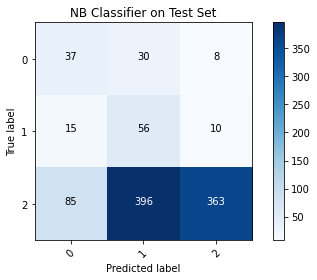

In [17]:
x_test = x_test['reviewText']
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "NB Classifier on Test Set")
print(classification_report(y_test, prediction))